# Keras VAE

https://keras.io/examples/generative/vae/

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install h5py

In [ ]:
import time
startTime = time.time()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

#cleaning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#VAE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#testing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# #tuning hyper params
# import shutil
# import keras_tuner
# from kerastuner.tuners import BayesianOptimization

#h5
import h5py

# Define Homayra's RSMEs

In [ ]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

In [ ]:
def rmspe_1(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(y_true - y_pred) / y_true))*100

# Creating a sampling layer

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Build Encoder

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(6,))
x = layers.Dense(32, activation="relu")(encoder_inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()


# Build Decoder


In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation="relu")(latent_inputs)
x = layers.Dense(32, activation="relu")(x)
decoder_outputs = layers.Dense(1)(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")


# Define VAE as Model with custom train_step

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, num_columns, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.num_columns = num_columns
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        x_train, y_train = data  # Unpack the input data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x_train)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(y_train, reconstruction)
            )
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        _, _, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed


# Get Data

In [ ]:
#paths
mainPath = '/content/drive/MyDrive/REU 2023 Team 1: Ice Bed Topography Prediction/Research/Yi_Work/'

data_full_ = mainPath + '/Data/data_full.csv' #training and test combined

data_1201_ = mainPath + '/Data/df_1201_validation_data.csv'
# h5SavePath = mainPath + "/Data/myh5"

In [ ]:
#read data in
df_all = pd.read_csv(data_full_)

df1201 = pd.read_csv(data_1201_)

#drop dumb columns
df1201 = df1201.drop(columns = ['Unnamed: 0'])
df_all = df_all.drop(columns = ['Unnamed: 0'])

#compute vmag to match final process for result comparison.
df_all['v_mag'] = np.sqrt(df_all['surf_vx']**2 + df_all['surf_vy']**2)
df1201['v_mag'] = np.sqrt(df1201['surf_vx']**2 + df1201['surf_vy']**2)

#1201 drop location variables
df1201_feats = df1201.drop(columns = ['surf_x', 'surf_y'])

#df_all drop location variables
df_all_feats_target = df_all.drop(columns = ['surf_x', 'surf_y', 'track_bed_x', 'track_bed_y'])

#1201 order to align with df_all
df1201_feats_ordered = df1201_feats[['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB', 'v_mag']]

#set the feature variables to our independent characteristic variables
feature_cols = ['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB', 'v_mag']

#split into X and Y
X_given = df_all_feats_target[feature_cols]
Y_given = df_all_feats_target['track_bed_target']

#combine all known X and validation 1201 X for standardizing
X_all = np.concatenate((X_given, df1201_feats_ordered))

#make y into a dataframe to be standardized
Y_all = pd.DataFrame(Y_given)

#standardize
#Not setting feature range, let it be automatically determined
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_all_std = scaler_X.fit_transform(X_all)
Y_all_std = scaler_Y.fit_transform(Y_all)

#split of 1201 data from X_all_std
X_non1201 = X_all_std[0:632706,:]
X_1201_data = X_all_std[632706:, :]

#generate a randomseed for training and testing split
generated = 168
print(f"Rand Generated Split Seed: {generated}")

#set the train-test split
#60-40 showed the most promising from previous research
train_size_ = .6

#split training and test from df_all
x_train, x_test, y_train, y_test = train_test_split(X_non1201, Y_all_std, train_size = train_size_, test_size = 1-train_size_, random_state = generated)
#get validation data
val_split = .2 #can change as needed
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 1-val_split, test_size = val_split, random_state = generated)

Rand Generated Split Seed: 168


# Train

In [ ]:
%%time
vae = VAE(encoder, decoder, num_columns=6)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=300, batch_size=128)

print("All done. Yay!")

Epoch 1/300
2373/2373 [==============================] - 19s 6ms/step - loss: 0.9310 - reconstruction_loss: 0.7118 - kl_loss: 0.1744 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/300
2373/2373 [==============================] - 11s 5ms/step - loss: 0.8308 - reconstruction_loss: 0.5998 - kl_loss: 0.2231 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/300
2373/2373 [==============================] - 6s 3ms/step - loss: 0.8081 - reconstruction_loss: 0.5672 - kl_loss: 0.2366 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/300
2373/2373 [==============================] - 8s 3ms/step - loss: 0.7894 - reconstruction_loss: 0.5429 - kl_loss: 0.2448 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/300
2373/2373 [==============================] - 6s 3ms/step - loss: 0.7747 - reconstructi

In [ ]:
_,_, y_pred_test = vae.encoder.predict(x_test)
reconstructed_predictions = decoder.predict(y_pred_test)
print((reconstructed_predictions).shape)

7909/7909 [==============================] - 10s 1ms/step
(253083, 1)


In [ ]:
_,_, y_pred_train = vae.encoder.predict(x_train)
reconstructed_predictions_train = decoder.predict(y_pred_train)
print((reconstructed_predictions_train).shape)

9491/9491 [==============================] - 14s 1ms/step
(303698, 1)


In [ ]:
#convert to normal
#test
y_test_given_full_range = scaler_Y.inverse_transform(y_test.reshape(-1,1))
test_predict_full_scale = scaler_Y.inverse_transform(reconstructed_predictions)


In [ ]:
# Evaluate the model performance
print("Test stats")
#LOSSES
print('RMSE:',np.sqrt(mean_squared_error(y_test_given_full_range, test_predict_full_scale)))
print('RMSE Percentage:',rmspe(y_test_given_full_range, test_predict_full_scale))
# print('RMSE Percentage-1:',rmspe_1(y_test_given_full_range, test_predict_full_scale))
print('Mean Absolute Error:', mean_absolute_error(y_test_given_full_range, test_predict_full_scale))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test_given_full_range, test_predict_full_scale))
print('R^2 Score:', r2_score(y_test_given_full_range, test_predict_full_scale))

Test stats
RMSE: 106.88397919315574
RMSE Percentage: 7943.687456369629
Mean Absolute Error: 83.7981908133659
Mean Absolute Percentage Error: 1.2945608672948248
R^2 Score: 0.6477257978129755


In [ ]:
print("Predicting 1201")
start1201Prediction = time.time()

_,_, y_pred_train = vae.encoder.predict(X_1201_data)
y_pred_1201 = decoder.predict(y_pred_train)
# print((reconstructed_predictions_train).shape)
# y_pred_1201 = model.predict(X_1201_data)
pred1201_normScale = scaler_Y.inverse_transform(y_pred_1201)

end1201Prediction = time.time()
print(f"Predicting 1201 Complete.\nTime taken: {end1201Prediction-start1201Prediction:.03f}ms")

Predicting 1201
45076/45076 [==============================] - 63s 1ms/step
Predicting 1201 Complete.
Time taken: 221.178ms


In [ ]:
y_Predict_1201_full_flatten=pred1201_normScale.flatten()
prediction_on_1201_2D=y_Predict_1201_full_flatten.reshape(1201,1201)

In [ ]:
d1201Comparison = pd.DataFrame(prediction_on_1201_2D)

#transpose the datasets to face the correct NSEW directions.
data_set1 = np.transpose(d1201Comparison)
data_set1 = np.flipud(data_set1)

In [ ]:
modelNameYoureRunning = "VAE"
interpolatedDataYoureRunning = "Nearest Neighbors"

<ipython-input-24-9f5060df6350>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels(reversed(axs.get_yticklabels()))  # Reverse the y-axis tick labels


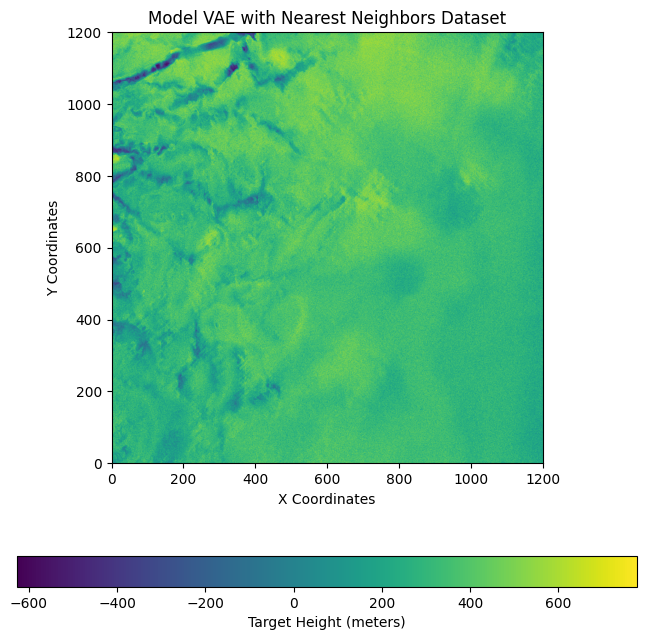

In [ ]:
if interpolatedDataYoureRunning == "NN":
  print("I told you not to use that name. It's not technically correct. Please go back and correct that.")
else:
  figRunName = f"Model {modelNameYoureRunning} with {interpolatedDataYoureRunning} Dataset"
  min_value = -626.96027
  max_value = 778.96765

  # Create a figure and subplots
  fig, axs = plt.subplots(1, 1, figsize=(8, 8))

  # Assuming data_set1 is defined and contains your data
  # Plot the first data set with shared color scale
  im1 = axs.imshow(data_set1, vmin=min_value, vmax=max_value)
  axs.set_title(f'{figRunName}')
  axs.set_yticklabels(reversed(axs.get_yticklabels()))  # Reverse the y-axis tick labels
  axs.set_xlabel("X Coordinates")
  axs.set_ylabel("Y Coordinates")

  # Define the colormap
  colors = [
      (0.0, 0.0, 0.0),    # Black
      (0.0, 0.0, 0.3),    # Darker blue
      (0.0, 0.0, 0.5),    # Dark blue
      (0.0, 0.0, 0.7),    # Blue
      (0.0, 0.0, 1.0),    # Blue
      (0.0, 0.4, 0.8),    # Lighter blue
      (0.0, 0.6, 0.2),    # Dark green
      (0.0, 0.7, 0.3),    # Green
      (0.2, 0.8, 0.4),    # Light green
      (1.0, 0.8, 0.0),    # Orange
      (1.0, 0.0, 0.0),    # Red
  ]
  mapColor = LinearSegmentedColormap.from_list('WaterTreesMountains', colors)

  # Add colorbar to the plot
  fig.colorbar(im1, label="Target Height (meters)", ax=axs, location='bottom')

  plt.show()
  plt.close()